# Introduction

Now that we have the symbolic equations of motion we need to transform them into Python functions that can be evaluated for use in numerical integration. [Numerical integration](http://en.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations) is required to solve the ordinary differential initial value problem and allow us to see how the states change through time.

# Setup

Load the solutions from the previous notebooks:

In [1]:
from solution.equations_of_motion import *

To setup the numerical values and integrate the equations of motion we will need some functions from NumPy for numerical arrays:

In [2]:
from numpy import deg2rad, rad2deg, array, zeros, linspace

We will need a ODE numerical integration routine from SciPy:

In [3]:
from scipy.integrate import odeint

We can use PyDy's ODE function generator to transform the symbolic equations into numerical functions:

In [4]:
from pydy.codegen.ode_function_generators import generate_ode_function

Once again, let's display the symbolics nicely.

In [5]:
from sympy.physics.vector import init_vprinting, vlatex

In [6]:
init_vprinting(use_latex='mathjax', pretty_print=False)

Once we get a solution for how the state changes over time, it is nice to visualize it. The simplest way to do this is to plot the trajectories versus time. We can use the matplotlib library to do this. First enable inline plotting:

In [7]:
%matplotlib inline

Import a few functions for plotting:

In [8]:
from matplotlib.pyplot import plot, legend, xlabel, ylabel, rcParams

And set the default figure size to be larger:

In [9]:
rcParams['figure.figsize'] = (14.0, 6.0)

# Variables

The first step is to gather all of the variables in the equations of motion into lists. We will need the constants, coordinates, speeds, and the specified inputs.

## Constants

There are twelve constants in the equations. Put them into a list.

In [10]:
constants = [lower_leg_length,
             lower_leg_com_length,
             lower_leg_mass,
             lower_leg_inertia,
             upper_leg_length,
             upper_leg_com_length,
             upper_leg_mass,
             upper_leg_inertia,
             torso_com_length,
             torso_mass,            
             torso_inertia,
             g]
constants
             

[l_L, d_L, m_L, I_Lz, l_U, d_U, m_U, I_Uz, d_T, m_T, I_Tz, g]

## Time Varying

The coordinates and speeds make up the states and there are three time varying specified inputs to the system, the joint torques.

In [11]:
coordinates = [theta1, theta2, theta3]
coordinates

[theta1, theta2, theta3]

In [12]:
speeds = [omega1, omega2, omega3]
speeds

[omega1, omega2, omega3]

## Exercise

Make a list called `specified` that contains the three torque magnitude variables: $T_a$, $T_k$, and $T_h$.

In [14]:
# %load exercise_solutions/n07_simulation_torque-magnitude.py
specified = [ankle_torque, knee_torque, hip_torque]

# Generate the Numerical ODE Function

Ordinary differential equation integrators, like `scipy.integrate.odeint`, require a function that numerically evaluates the right hand side of the coupled first order ordinary differential equations. We have the symbolic form of the mass matrix and the forcing vector available. The `generate_ode_function` function generates a function from the symbolic expressions that fits the form needed for `odeint`.

`odeint` is an ODE integrator based on the `lsoda` routine from ODEPACK that works well for both non-stiff and stiff ODEs. Notice that it requres the right hand side function, the initial conditions of the state, a time vector. We will also pass in extra arguments, `args`, of the right hand side function.

In [15]:
help(odeint)

Help on function odeint in module scipy.integrate.odepack:

odeint(func, y0, t, args=(), Dfun=None, col_deriv=0, full_output=0, ml=None, mu=None, rtol=None, atol=None, tcrit=None, h0=0.0, hmax=0.0, hmin=0.0, ixpr=0, mxstep=0, mxhnil=0, mxordn=12, mxords=5, printmessg=0, tfirst=False)
    Integrate a system of ordinary differential equations.
    
    .. note:: For new code, use `scipy.integrate.solve_ivp` to solve a
              differential equation.
    
    Solve a system of ordinary differential equations using lsoda from the
    FORTRAN library odepack.
    
    Solves the initial value problem for stiff or non-stiff systems
    of first order ode-s::
    
        dy/dt = func(y, t, ...)  [or func(t, y, ...)]
    
    where y can be a vector.
    
    .. note:: By default, the required order of the first two arguments of
              `func` are in the opposite order of the arguments in the system
              definition function used by the `scipy.integrate.ode` class and
     

To create the function, simply pass in $\mathbf{M}$, $\mathbf{f}$, and the lists of variables in the system.

In [16]:
right_hand_side = generate_ode_function(forcing_vector, coordinates,
                                        speeds, constants,
                                        mass_matrix=mass_matrix,
                                        specifieds=specified)

We see that the result is a function.

In [17]:
type(right_hand_side)

function

And the doc string gives information on the type of the arguments needed to evaluate it:

In [18]:
help(right_hand_side)

Help on function rhs in module pydy.codegen.ode_function_generators:

rhs(*args)
    Returns the derivatives of the states, i.e. numerically evaluates the right
    hand side of the first order differential equation.
    
    x' = f(x, t, r, p)
    
    Parameters
    x : ndarray, shape(6,)
        The state vector is ordered as such:
            - theta1(t)
            - theta2(t)
            - theta3(t)
            - omega1(t)
            - omega2(t)
            - omega3(t)
    t : float
        The current time.
    r : dictionary; ndarray, shape(3,); function
    
        There are three options for this argument. (1) is more flexible but
        (2) and (3) are much more efficient.
    
        (1) A dictionary that maps the specified functions of time to floats,
        ndarrays, or functions that produce ndarrays. The keys can be a single
        specified symbolic function of time or a tuple of symbols. The total
        number of symbols must be equal to 3. If the value is a
 

# Set the Initial Conditions, Parameter Values, and Time Array

We will set the intial values of the speeds to be zero and the coordinates to be offset from vertical at 2 degrees. First make an array of zeros:

In [19]:
x0 = zeros(6)
x0

array([0., 0., 0., 0., 0., 0.])

And then set the first three values, $\theta_{1,2,3}$, to 2 degrees:

In [20]:
x0[:3] = deg2rad(2.0)
x0

array([0.03490659, 0.03490659, 0.03490659, 0.        , 0.        ,
       0.        ])

The right hand side function requires numerical values of all the constants to be passed in and values for the specified joint torques. Here we will use typical values from body segment parameter measurements which were generated from the [Yeadon](http://yeadon.readthedocs.org/en/latest/) Python package (`male1.txt`). Make sure the units are all consistent!

In [24]:
numerical_constants = array([0.611,  # lower_leg_length [m]
                             0.387,  # lower_leg_com_length [m]
                             6.769,  # lower_leg_mass [kg]
                             0.101,  # lower_leg_inertia [kg*m^2]
                             0.424,  # upper_leg_length [m]
                             0.193,  # upper_leg_com_length
                             17.01,  # upper_leg_mass [kg]
                             0.282,  # upper_leg_inertia [kg*m^2]
                             0.305,  # torso_com_length [m]
                             32.44,  # torso_mass [kg]
                             1.485,  # torso_inertia [kg*m^2]
                             9.81],  # acceleration due to gravity [m/s^2]
                            ) 

## Exercise

For this first simulation we will set the three joint torques equal to zero for the duration of the simulation. Created a Python variale `numerical_specified` which is a NumPy array of length three and each entry is equal to zero.

We can use the `linspace` function to generate a time vector over 10 secs such that `odeint` returns results at 60 Hz.

In [29]:
# %load exercise_solutions/n07_simulation_sim-setup.py
numerical_specified = zeros(3)

args = {'constants': numerical_constants,
        'specified': numerical_specified}

frames_per_sec = 60
final_time = 10

t = linspace(0.0, final_time, final_time * frames_per_sec)

# Integrate the Equations of Motion

The right hand side function can now be evaluated numerically given a current value of the states, a value for time, and the numerical values for all the constants and specified values in the equations of motion:

In [30]:
right_hand_side(x0, 0.0, numerical_specified, numerical_constants)

array([ 0.        ,  0.        ,  0.        , -1.76725648,  5.52084443,
       -2.62845189])

Now we can solve the initial value problem and simulate the motion. As shown above, `odeint` requires the function to integrate `right_hand_side`, the initial conditions `x0`, the time vector `t`, and the extra arguments `args`:

In [31]:
y = odeint(right_hand_side, x0, t, args=(numerical_specified, numerical_constants))

The `y` variable now contains a 2D array that gives the trajectories of the states as a function of time.

In [32]:
y.shape

(600, 6)

# Plot the results

We can plot the first 3 columns of `y` versus `t` so see how the three angles change throughout time.

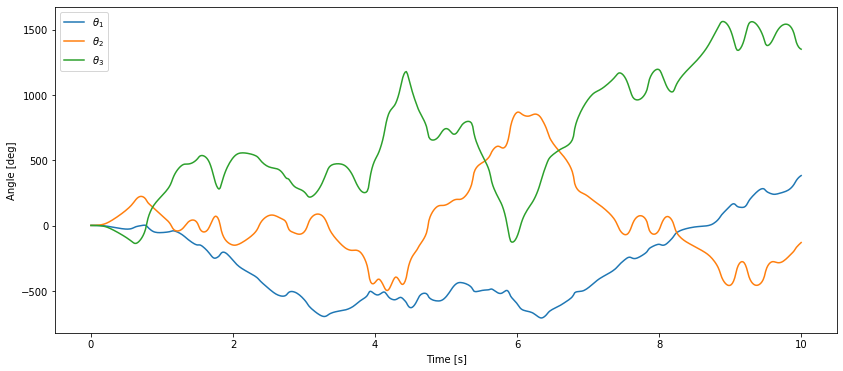

In [33]:
plot(t, rad2deg(y[:, :3]))
xlabel('Time [s]')
ylabel('Angle [deg]')
legend(["${}$".format(vlatex(c)) for c in coordinates])

What does this graph tell us? How does the system behave?

## Exercise

Now as an exercise, plot the generalized speeds (i.e. the last three states).

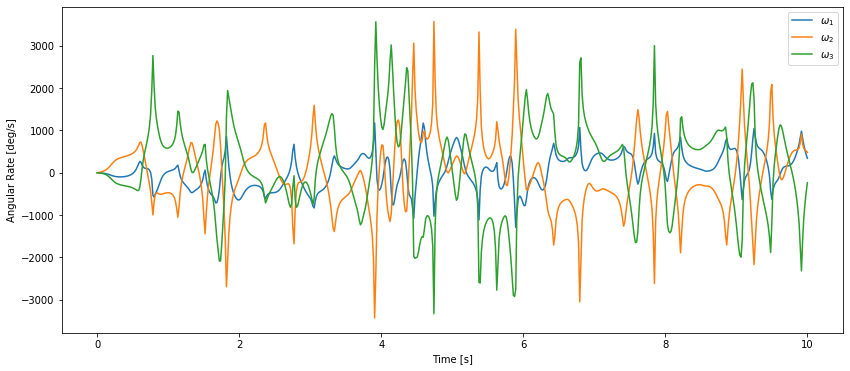

In [35]:
# %load exercise_solutions/n07_simulation_plot-speeds.py
plot(t, rad2deg(y[:, 3:]))
xlabel('Time [s]')
ylabel('Angular Rate [deg/s]')
legend(["${}$".format(vlatex(s)) for s in speeds])